In [ ]:
# Import library
from __future__ import absolute_import,division,print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import os
from os import listdir
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Conv2DTranspose,Reshape
from keras.models import Sequential
from keras.layers import LeakyReLU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model, to_categorical

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint

# !pip install tensorflow-addons==0.8.3
# !pip install tensorflow==2.2.0-rc3

import tensorflow as tf
# import tensorflow_addons as tfa

import tensorflow.keras.layers as layers
import time
from IPython import display

# Install dependency untuk cropping gambar
!pip install imutils
import imutils

# for mathematical operations
import random
import math
# for visualizations
import seaborn as sns
# for image related operations
import PIL
import time
# for warnings
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
warnings.filterwarnings("ignore")

from PIL import Image, ImageChops

# from keras.applications.resnet import ResNet50
# from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow import keras
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dataset dari google drive
file_path = "/content/drive/MyDrive/brain_tumor_dataset"
file_path

'/content/drive/MyDrive/brain_tumor_dataset'

In [ ]:
# fungsi trim background
def trim(im):
  bg = Image.new("RGB", im.size, im.getpixel((0,0)))
  diff = ImageChops.difference(im.convert("RGB"), bg)
  diff = ImageChops.add(diff, diff)
  bbox = diff.getbbox()
  # if bbox:
  return im.crop(bbox)

In [ ]:
# Fungsi untuk crop gambar
def crop_mri(image, plot=False):
    # Ubah gambar kedalam bentuk grayscale
    image = np.array(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray = cv2.GaussianBlur(gray, (5, 5), 0)

    morph = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    morph = cv2.erode(morph, None, iterations=2)
    morph = cv2.dilate(morph, None, iterations=2)

    # Cari kontur dari gambar yang sudah dimorph, kemudian ambil yang terbesar
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Set extreme point
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop gambar dengan 4 extreme point yang sudah diset diatas (left, right, top, bottom)
    cropped = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.subplot(1, 2, 2)
        plt.imshow(cropped)
        plt.title("Cropped Image")

    return cropped

In [ ]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = Image.open(directory + '/' + filename).convert('RGB')
            # trimmed = trim(im)
            # image = gaussian_blur(image)
            image = crop_mri(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            X.append(image)

            # Jika direktori asal memiliki nama 'yes' maka akan diberi label 1,
            # Jika bukan maka diberi label 0
            if(directory[-3:] == 'yes'):
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
file_yes = file_path+"/yes"
file_no = file_path+"/no"

IMG_WIDTH, IMG_HEIGHT = (256, 256)

X, y = load_data([file_yes, file_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 256, 256, 3)
y shape is: (253, 1)


In [ ]:
# Fungsi untuk split data training, validasi, dan testing
def split_data(X, y, test_size):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Panggil fungsi split data dengan parameter data X, y, dan ukuran test sebesar 30% total data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

# Cek jumlah training, validation, dan test sample sebelum augmentasi
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 202
number of validation examples = 26
number of test examples = 25


Save splitted data

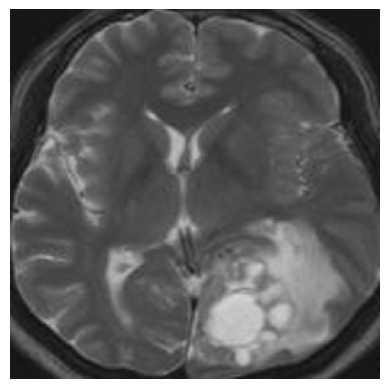

In [ ]:
for i in range(len(X_train)):
  img = X_train[i]
  plt.imshow(img)
  plt.axis('off')
  if y_train[i] == 1:
    plt.savefig("/content/drive/MyDrive/Data split skripsi/train_data/yes/train_image_{:04d}.png".format(i+1), bbox_inches='tight',pad_inches = 0)
  else:
    plt.savefig("/content/drive/MyDrive/Data split skripsi/train_data/no/train_image_{:04d}.png".format(i+1), bbox_inches='tight',pad_inches = 0)
    # plt.show()

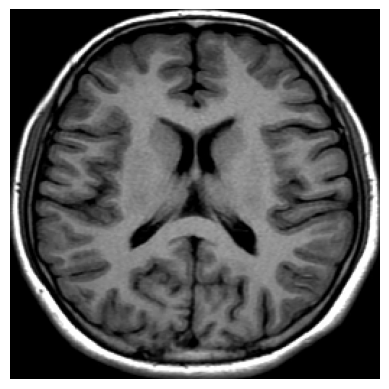

In [ ]:
for i in range(len(X_test)):
    img = X_test[i]
    plt.imshow(img)
    plt.axis('off')
    if y_test[i] == 1:
      plt.savefig("/content/drive/MyDrive/Data split skripsi/test_data/yes/test_image_{:04d}.png".format(i+1), bbox_inches='tight',pad_inches = 0)
    else:
      plt.savefig("/content/drive/MyDrive/Data split skripsi/test_data/no/test_image_{:04d}.png".format(i+1), bbox_inches='tight',pad_inches = 0)
    # plt.show()

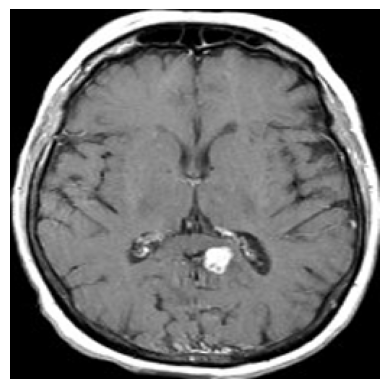

In [ ]:
for i in range(len(X_val)):
    img = X_val[i]
    plt.imshow(img)
    plt.axis('off')
    if y_val[i] == 1:
      plt.savefig("/content/drive/MyDrive/Data split skripsi/val_data/yes/val_image_{:04d}.png".format(i+1), bbox_inches='tight',pad_inches = 0)
    else:
      plt.savefig("/content/drive/MyDrive/Data split skripsi/val_data/no/val_image_{:04d}.png".format(i+1), bbox_inches='tight',pad_inches = 0)
    # plt.show()